## Download & Import libraries 

In [ ]:
!pip install lightgbm
!pip -q install yellowbrick==1.3
!pip -q install kneed
!pip -q install factor_analyzer

In [ ]:
# Code to read csv file into Colaboratory:
!pip -q install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.metrics import mean_absolute_percentage_error  ### Colab Python version too low for this
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from lightgbm import LGBMRegressor

# Factor Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from kneed import KneeLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import plotly.express as px

## Read & Prepare Data

In [ ]:
id = '1bj0yDcTdBedCTQWKaC0JpidjC8QS8Tqz'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('combined_data.csv') 

In [ ]:
df = df[df.popularity != 0]

In [ ]:
albumn_dummies = pd.get_dummies(df.album_type)
df2 = pd.concat([df, albumn_dummies], axis=1)
df2.head()

In [ ]:
df2.drop(["is_local", "time_signature", "album_type", "artists", "album_name", "name"], axis=1, inplace=True)

In [ ]:
X, y = df2.iloc[:,df2.columns != 'popularity'],df2.iloc[:,df2.columns == 'popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print("Size of training data = " + str(X_train.shape[0]))
print("Size of testing data = " + str(X_test.shape[0]))

## Factor Analysis

In [ ]:
df = pd.read_csv('combined_data.csv')

In [ ]:
df.drop(["is_local", "time_signature"], axis=1, inplace=True)
df2 = df[df["album_type"] == "album"] # Select only album
df3 = df2[df2["popularity"] != 0] # Non-zero popularity
df4 = df2[df2["popularity"] == 0].sample(n=300, random_state=3101)
df2 = pd.concat([df3,df4])
df2.reset_index(drop=True, inplace=True)
df2

In [ ]:
_ , p_value = calculate_bartlett_sphericity(df2)
p_value

In [ ]:
_, kmo_score = calculate_kmo(df2)
kmo_score 

In [ ]:
#A common procedure is to centre each variable by subtracting its mean from every observation, and then rescale those 
#centred values as units of standard deviation. This is commonly called standardizing, normalizing, or Z scoring the data.
colnames = list(df2.columns)
scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(df2))
scaled_features.columns = colnames


In [ ]:
scaled_features.describe()

In [ ]:
corr = scaled_features.corr()

In [ ]:
corr

In [ ]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#We will set n_components to 9

N = 9
pca = PCA(n_components=N)
pca.fit(df2)

In [ ]:
#outputs an array of the variance explained by each component scaled to the total of 1.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

In [ ]:
# Cumulative sum of principal components i.e. Cumulative variance of 2 = PC1 variance + PC2 variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))
cumulative_variance

In [ ]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')

In [ ]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [ ]:
scree_plot = pd.DataFrame(pca.explained_variance_ratio_)
scree_plot.columns = ["Variance Explained by PC"]
s = (str(i) for i in range(1,N+1))
scree_plot = scree_plot.join(pd.DataFrame(s))
scree_plot.columns = ["Variance Explained by PC", 'PC Number']
scree_plot = scree_plot.join(pd.DataFrame(cumulative_variance))
scree_plot.columns = ["Variance Explained by PC", 'PC Number', 'cumulative_variance']
scree_plot

In [ ]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')

In [ ]:
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.lineplot(data = scree_plot, x = 'PC Number', y = 'cumulative_variance', marker="o", linewidth = 3.5, color = 'green')
sns.barplot(data = scree_plot, x = 'PC Number', y = 'Variance Explained by PC').set(title = 'Variance')
ax.axhline(0.7, color = 'red', linewidth = 2.5)
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.lineplot(data = scree_plot, x = "PC Number", y = "Variance Explained by PC", marker="o", linewidth = 3.5).set(title='Scree Plot')

In [ ]:
kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow

In [ ]:
pca.explained_variance_

In [ ]:
#Plot the scree plot using pca.explained_variance_ instead. What does the explained variance show?
#Link: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_)
plt.plot(range(1,N+1),pca.explained_variance_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel("Eigenvalues")
plt.grid()

In [ ]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [ ]:
def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [ ]:
evaluate_pcs(3,scaled_features[colnames])

,PC1,PC2,PC3
total_tracks,,,0.695477
explicit,,0.709152,
danceability,,0.665521,
energy,0.893354,,
key,,,
loudness,0.851032,,
mode,,,
speechiness,,0.677237,
acousticness,-0.770457,,
instrumentalness,,,


In [ ]:
print(CronbachAlpha(scaled_features[['energy','loudness','acousticness']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['explicit','danceability','speechiness']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['total_tracks']])) #Reliabililty of PC3
#Reliability for all the features
#If we had a diff sample, would we still get these 4PCs with the same features with high loadings


# Now, on to test the reliability of the PCs using Cronbach's alpha, which is a
# measure of the internal consistency of the PCs. The higher their internal
# consistencies, the greater the chance the loadings generated using other
# samples of this data will be similar.

# All results are greater than our minimum requirement of 0.70. This means the
# PCs generated are reliable.

## Linear Regression

In [ ]:
linear_model = LinearRegression(normalize=True).fit(X_train, y_train)
linear_preds = linear_model.predict(X_test)
linear_train_pred = linear_model.predict(X_train)

In [ ]:
# R^2
test_r2 = r2_score(y_test, linear_preds)
train_r2 = r2_score(y_train, linear_train_pred)

# RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, linear_train_pred))

# MAE (Mean Absolute Error)
test_mae = mean_absolute_error(y_test, linear_preds)
train_mae = mean_absolute_error(y_train, linear_train_pred)

# MAPE (Mean Absolute Percentage Error)
#test_mape = mean_absolute_percentage_error(y_test, linear_preds)
#train_mape = mean_absolute_percentage_error(y_train, linear_train_pred)

In [ ]:
print(test_r2, train_r2)
print(test_rmse, train_rmse)
print(test_mae, train_mae)
#print(test_mape, train_mape)

## DecisionTreeRegressor

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

df_original = pd.read_csv('combined_data.csv')
df_original['popularity'].value_counts().sort_index(ascending=True).plot(kind = "bar")
df1 = df_original[df_original["popularity"] != 0] # Non-zero popularity
df2 = df_original[df_original["popularity"] == 0].sample(n=300, random_state=3101)
df3 = pd.concat([df1,df2])
df4 = df3[df3["instrumentalness"] != 0] # Non-zero popularity
df5 = df3[df3["instrumentalness"] == 0].sample(n=300, random_state=3101)
df6 = pd.concat([df4,df5])
df_acousticness = df6["acousticness"].replace(0,0.0000001)
df_instrumentalness = df6["instrumentalness"].replace(0,0.0000001)
df7 = df6.join(df_acousticness, lsuffix='_old', rsuffix='')
df8 = df7.join(df_instrumentalness, lsuffix='_old', rsuffix='')
df8.drop(["acousticness_old", "instrumentalness_old"], axis=1, inplace=True)
df8["acousticness"] = np.log(df8["acousticness"]) # log transformation
df8["instrumentalness"] = np.log(df8["instrumentalness"]) # log transformation
df8['explicit'].replace({True:1,False:0}, inplace = True)
df8.drop(["is_local", "time_signature", "album_name", "artists", "name", 'album_type'], axis=1, inplace=True)
df_clean = df8
popularity = df_clean.popularity
df_dt = df_clean.drop(['popularity'], axis = 1)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(df_dt, popularity, test_size=0.33, random_state=42)
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train_dt, y_train_dt)
predict_dtr = clf.predict(X_test_dt)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_scores(y_test,test_pred):
    # R^2
    test_r2 = r2_score(y_test, test_pred)

    # RMSE (Root Mean Squared Error)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    # MAE (Mean Absolute Error)
    test_mae = mean_absolute_error(y_test, test_pred)

    print(test_r2)
    print(test_rmse)
    print(test_mae)

    return

get_scores(y_test_dt, predict_dtr)

#rmse = np.sqrt(mean_squared_error(y_test_dt, predict_dtr))

#print("RMSE: %f" % (rmse)) #train with unscaled popularity

0.2342249945947168
25.41563436836768
15.89214898177921


In [ ]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(df_dt, popularity_scaled, test_size=0.33, random_state=42)
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train_dt, y_train_dt)
predict_dtr = clf.predict(X_test_dt)

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_dt, predict_dtr))

print("RMSE: %f" % (rmse))

RMSE: 0.255879


## LGBMRegressor + GridSearch

In [ ]:
# Proportion of validation set for early stopping in training set.
r = 0.1 
trainLen = round(len(X_train)*(1-r))

# Splitting training data to training and early stopping validation set.
X_train_1, X_val_1 = X_train.iloc[:trainLen,:], X_train.iloc[trainLen:,:]
y_train_1, y_val_1 = y_train[:trainLen], y_train[trainLen:]


# Defining parameter space for grid search.
gridParams = {
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [0.1, 1.0, 2.0],
}

# Define lightgbm and grid search.
reg = LGBMRegressor(learning_rate=0.1, n_estimators=1000, random_state=1000)
reg_gridsearch = GridSearchCV(reg, gridParams, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) 

# Model fit with early stopping.
reg_gridsearch.fit(X_train_1, y_train_1, early_stopping_rounds=100, eval_set=(X_val_1,y_val_1))

In [ ]:
reg_gridsearch.best_params_

In [ ]:
lgbm_reg = LGBMRegressor(colsample_bytree=0.8,
                         max_depth=9,
                         min_child_weight=0.1,
                         subsample=0.6,
                         learning_rate=0.1, n_estimators=1000, random_state=1000)

In [ ]:
lgbm_reg.fit(X_train, y_train)

In [ ]:
preds = lgbm_reg.predict(X_test)
train_pred = lgbm_reg.predict(X_train)

In [ ]:
# R^2
test_r2 = r2_score(y_test, preds)
train_r2 = r2_score(y_train, train_pred)

# RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(mean_squared_error(y_test, preds))
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# MAE (Mean Absolute Error)
test_mae = mean_absolute_error(y_test, preds)
train_mae = mean_absolute_error(y_train, train_pred)

# MAPE (Mean Absolute Percentage Error)
#test_mape = mean_absolute_percentage_error(y_test, preds)
#train_mape = mean_absolute_percentage_error(y_train, train_pred)

In [ ]:
print(test_r2, train_r2)
print(test_rmse, train_rmse)
print(test_mae, train_mae)
#print(test_mape, train_mape)

## LGBMRegressor + Randomised Search

In [ ]:
# Proportion of validation set for early stopping in training set.
r = 0.1 
trainLen = round(len(X_train)*(1-r))

# Splitting training data to training and early stopping validation set.
X_train_1, X_val_1 = X_train.iloc[:trainLen,:], X_train.iloc[trainLen:,:]
y_train_1, y_val_1 = y_train[:trainLen], y_train[trainLen:]

randParams = {
    'max_depth': stats.randint(3,13), # integer between 3 and 12
    'subsample': stats.uniform(0.6,1.0-0.6), # value between 0.6 and 1.0
    'colsample_bytree': stats.uniform(0.6,1.0-0.6), # value between 0.6 and 1.0
    'min_child_weight': stats.uniform(0.1,10.0-0.1), # value between 0.1 and 10.0
}

# Define lightgbm and grid search. Find n_iter and random_state were added to searchCV function parameters.
reg = LGBMRegressor(learning_rate=0.1, n_estimators=1000, random_state=1000)
reg_randsearch = RandomizedSearchCV(reg, randParams, cv=5, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, random_state=2222) 

# Model fit with early stopping.
reg_randsearch.fit(X_train_1, y_train_1, early_stopping_rounds=100, eval_set=(X_val_1,y_val_1))

In [ ]:
reg_randsearch.best_params_

In [ ]:
lgbm_rand = LGBMRegressor(colsample_bytree=0.8335107260075492,
                         max_depth=11,
                         min_child_weight=9.593483475672347,
                         subsample=0.8082607886651456,
                         learning_rate=0.1, n_estimators=1000, random_state=1000)

In [ ]:
lgbm_rand.fit(X_train, y_train)

In [ ]:
preds = lgbm_rand.predict(X_test)
train_pred = lgbm_rand.predict(X_train)

In [ ]:
# R^2
test_r2 = r2_score(y_test, preds)
train_r2 = r2_score(y_train, train_pred)

# RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(mean_squared_error(y_test, preds))
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# MAE (Mean Absolute Error)
test_mae = mean_absolute_error(y_test, preds)
train_mae = mean_absolute_error(y_train, train_pred)

# MAPE (Mean Absolute Percentage Error)
#test_mape = mean_absolute_percentage_error(y_test, preds)
#train_mape = mean_absolute_percentage_error(y_train, train_pred)

In [ ]:
print(test_r2, train_r2)
print(test_rmse, train_rmse)
print(test_mae, train_mae)
#print(test_mape, train_mape)

## RandomForestRegressor + GridSearch

In [ ]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Defining parameter space for grid search.
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,7,8,10],
    'max_features': [3,4,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [4,6],
    'n_estimators': [200, 300, 1000]
}


# Define lightgbm and grid search.
rf = RandomForestRegressor(random_state=3101)
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 1)

# Model fit with early stopping.
rf_grid_search.fit(X_train, y_train)

In [ ]:
rf_grid_search.best_params_

In [ ]:
rf = RandomForestRegressor(random_state=3101,
                           max_depth=10,
                           max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=4,
                           n_estimators=1000)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
preds = rf.predict(X_test)
train_pred = rf.predict(X_train)

In [ ]:
# R^2
test_r2 = r2_score(y_test, preds)
train_r2 = r2_score(y_train, train_pred)

# RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(mean_squared_error(y_test, preds))
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# MAE (Mean Absolute Error)
test_mae = mean_absolute_error(y_test, preds)
train_mae = mean_absolute_error(y_train, train_pred)

# MAPE (Mean Absolute Percentage Error)
test_mape = mean_absolute_percentage_error(y_test, preds)
train_mape = mean_absolute_percentage_error(y_train, train_pred)

In [ ]:
print(test_r2, train_r2)
print(test_rmse, train_rmse)
print(test_mae, train_mae)
print(test_mape, train_mape)

# EDA

## columns

In [ ]:
df = pd.read_csv('combined_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13283 entries, 0 to 13282
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album_type        13283 non-null  object 
 1   artists           13283 non-null  object 
 2   album_name        13283 non-null  object 
 3   total_tracks      13283 non-null  int64  
 4   explicit          13283 non-null  bool   
 5   is_local          13283 non-null  bool   
 6   name              13283 non-null  object 
 7   popularity        13283 non-null  int64  
 8   danceability      13283 non-null  float64
 9   energy            13283 non-null  float64
 10  key               13283 non-null  int64  
 11  loudness          13283 non-null  float64
 12  mode              13283 non-null  int64  
 13  speechiness       13283 non-null  float64
 14  acousticness      13283 non-null  float64
 15  instrumentalness  13283 non-null  float64
 16  liveness          13283 non-null  float6

In [ ]:
df.describe()

,total_tracks,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,13283.000000,1.328300e+04,13283.000000
mean,28.563427,39.415268,0.592730,0.663486,5.344651,-7.780605,0.638184,0.097425,0.226176,0.169908,0.215766,0.471164,122.483868,2.358598e+05,3.929534
std,37.836433,30.628680,0.163958,0.230423,3.581900,4.144280,0.480544,0.113599,0.289517,0.323072,0.185137,0.243032,27.683349,2.521494e+05,0.372003
min,1.000000,0.000000,0.000000,0.000020,0.000000,-41.766000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.360000e+03,0.000000
25%,10.000000,6.000000,0.484000,0.521000,2.000000,-9.084000,0.000000,0.037400,0.008415,0.000000,0.098800,0.275000,100.680500,1.757205e+05,4.000000
50%,15.000000,54.000000,0.600000,0.697000,6.000000,-6.829000,1.000000,0.053200,0.083900,0.000042,0.134000,0.464000,125.027000,2.137080e+05,4.000000
75%,26.000000,68.000000,0.713000,0.852000,8.000000,-5.218000,1.000000,0.101000,0.349500,0.077550,0.287000,0.657000,138.026000,2.547450e+05,4.000000
max,214.000000,100.000000,0.987000,1.000000,11.000000,1.027000,1.000000,0.961000,0.996000,1.000000,0.994000,0.984000,220.099000,5.042185e+06,5.000000


In [ ]:
df.isnull().sum()

album_type          0
artists             0
album_name          0
total_tracks        0
explicit            0
is_local            0
name                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

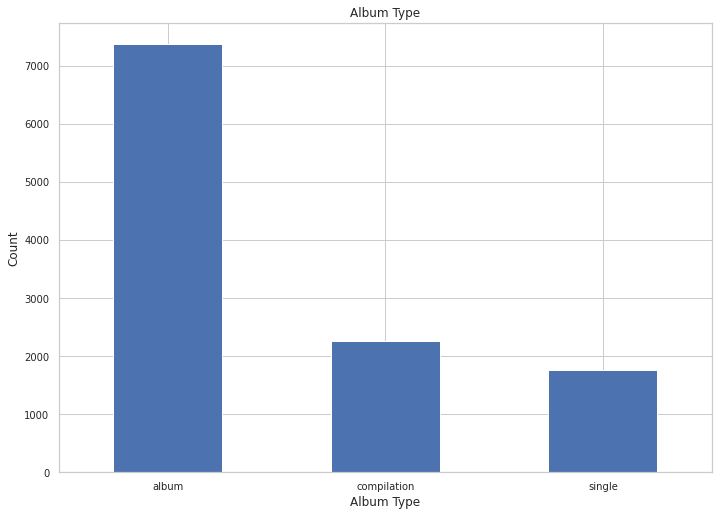

In [ ]:
df['album_type'].value_counts().plot.bar(fontsize=10, xlabel="Album Type", ylabel="Count", title="Album Type")
plt.xticks(rotation=0)

In [ ]:
df['artists'].value_counts().nlargest(10)

Various Artists                         1206
Armin van Buuren                         886
Armin van Buuren ASOT Radio              243
Taylor Swift                             111
David Bowie                               99
Robin Trower                              89
Drake                                     82
TandMMusic~TandMProductionCo~TandMTV      72
Trippie Redd                              69
The Cars                                  60
Name: artists, dtype: int64

In [ ]:
df['album_name'].value_counts().nlargest(10)

A State Of Trance Year Mix 2017 (Mixed by Armin van Buuren)    189
A State Of Trance Year Mix 2019 (Mixed by Armin van Buuren)    105
A State Of Trance Year Mix 2018 (Mixed by Armin van Buuren)    104
A State Of Trance Year Mix 2020 (Mixed by Armin van Buuren)    103
A State Of Trance Year Mix 2016 (Mixed by Armin van Buuren)    100
A State Of Trance Year Mix 2014 (Mixed by Armin van Buuren)    100
A State Of Trance Year Mix 2013 (Mixed by Armin van Buuren)     93
Five Years (1969 - 1973)                                        86
A State Of Trance Year Mix 2012 (Mixed by Armin van Buuren)     83
A State Of Trance Year Mix 2015 (Mixed by Armin van Buuren)     73
Name: album_name, dtype: int64

[Text(0.5, 1.0, 'Explicit')]

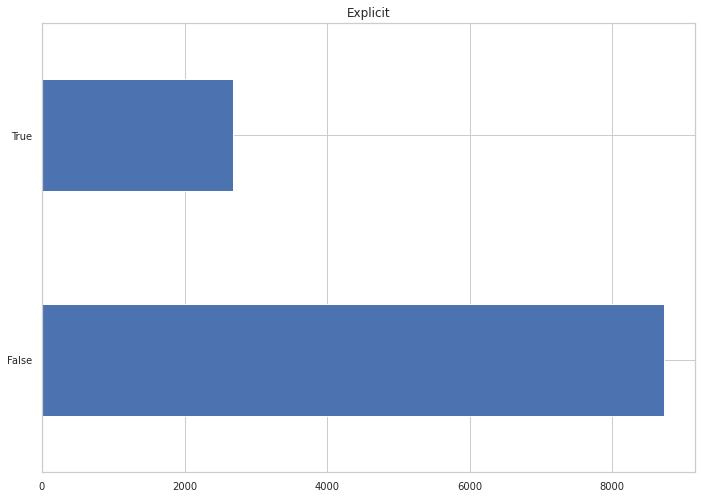

In [ ]:
df['explicit'].value_counts().plot(kind='barh', fontsize=10).set(title = 'Explicit')

[Text(0.5, 1.0, 'Explicit(Spotify)')]

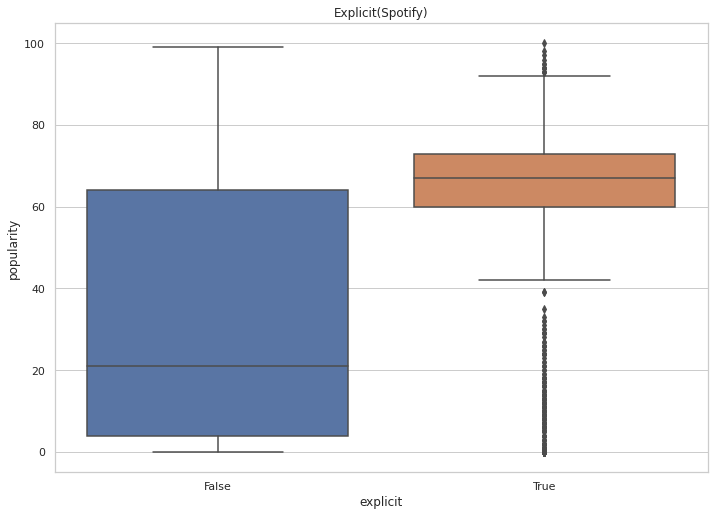

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.boxplot(x="explicit", y="popularity", data=df).set(title = 'Explicit(Spotify)')

In [ ]:
df['is_local'].value_counts()

False    13283
Name: is_local, dtype: int64

count    11398.00000
mean        45.93376
std         28.17499
min          1.00000
25%         14.00000
50%         59.00000
75%         69.00000
max        100.00000
Name: popularity, dtype: float64

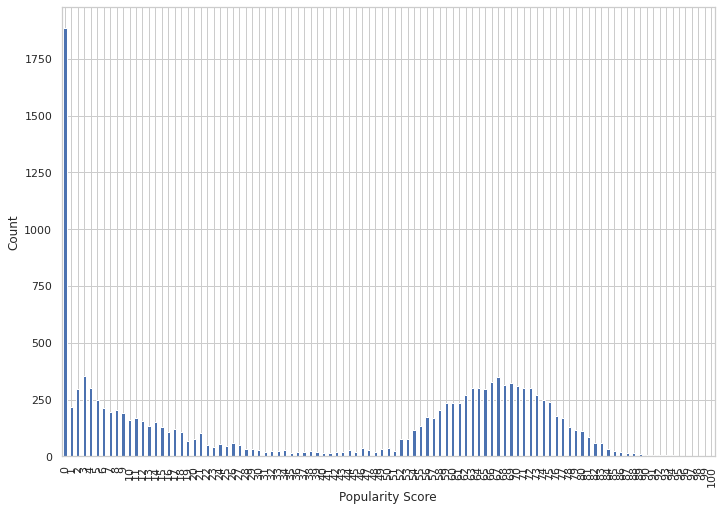

In [ ]:
df['popularity'].value_counts().sort_index(ascending=True).plot(kind = "bar", xlabel = "Popularity Score", ylabel = "Count")
df[df['popularity'] != 0]['popularity'].describe()

count    13283.000000
mean         0.592730
std          0.163958
min          0.000000
25%          0.484000
50%          0.600000
75%          0.713000
max          0.987000
Name: danceability, dtype: float64

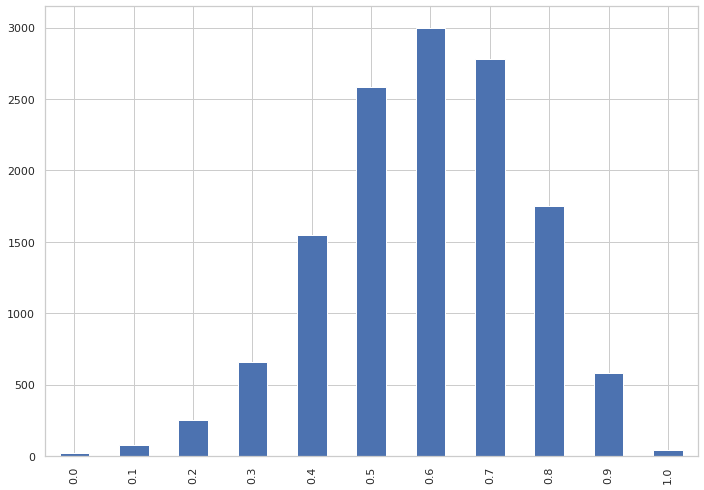

In [ ]:
df.round({'danceability': 1})['danceability'].value_counts().sort_index(ascending=True).plot(kind = "bar")
df['danceability'].describe()

count    13283.000000
mean         0.663486
std          0.230423
min          0.000020
25%          0.521000
50%          0.697000
75%          0.852000
max          1.000000
Name: energy, dtype: float64

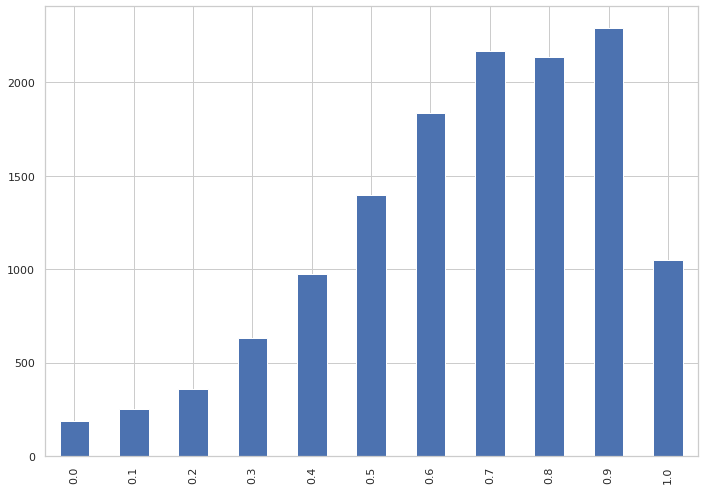

In [ ]:
df.round({'energy': 1})['energy'].value_counts().sort_index(ascending=True).plot(kind = "bar")
df['energy'].describe()

count    13283.000000
mean         5.344651
std          3.581900
min          0.000000
25%          2.000000
50%          6.000000
75%          8.000000
max         11.000000
Name: key, dtype: float64

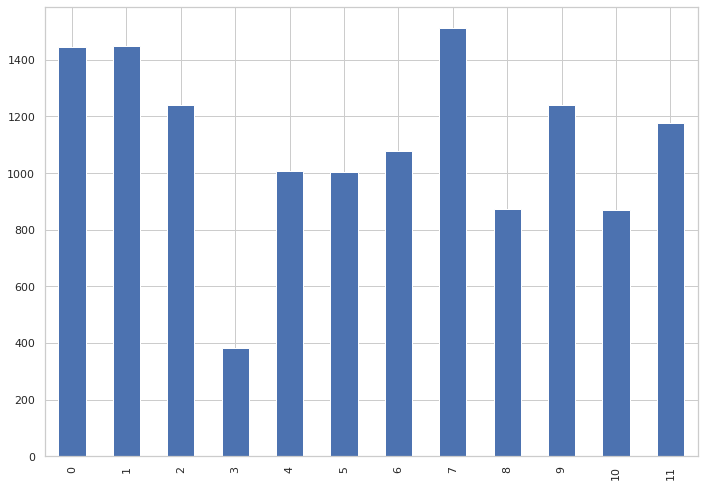

In [ ]:
df['key'].value_counts().sort_index(ascending=True).plot(kind = "bar")
df['key'].describe()

count    13283.000000
mean        -7.780605
std          4.144280
min        -41.766000
25%         -9.084000
50%         -6.829000
75%         -5.218000
max          1.027000
Name: loudness, dtype: float64

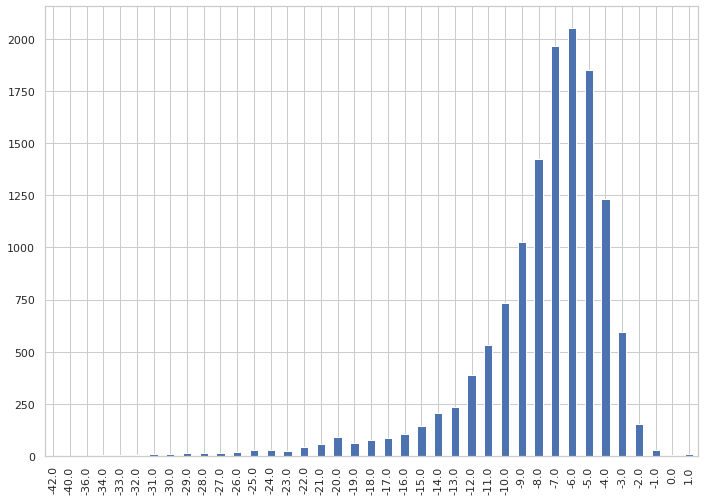

In [ ]:
df.round({'loudness': 0})['loudness'].value_counts().sort_index(ascending=True).plot(kind = "bar")
df['loudness'].describe()

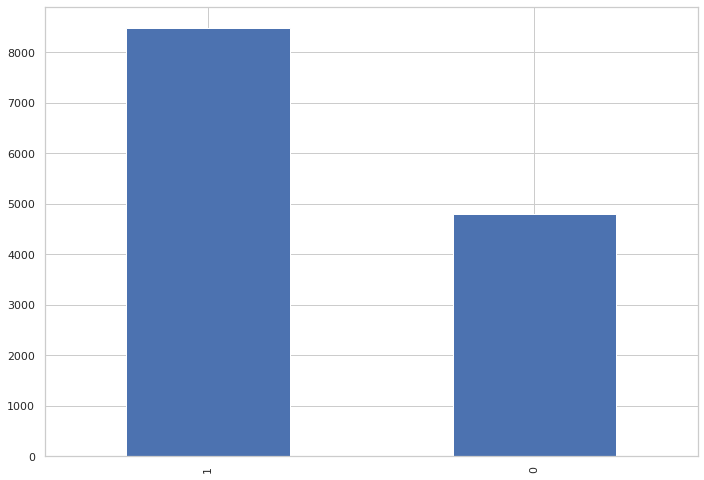

In [ ]:
df['mode'].value_counts().plot(kind = "bar")

[Text(0.5, 1.0, 'Speechiness')]

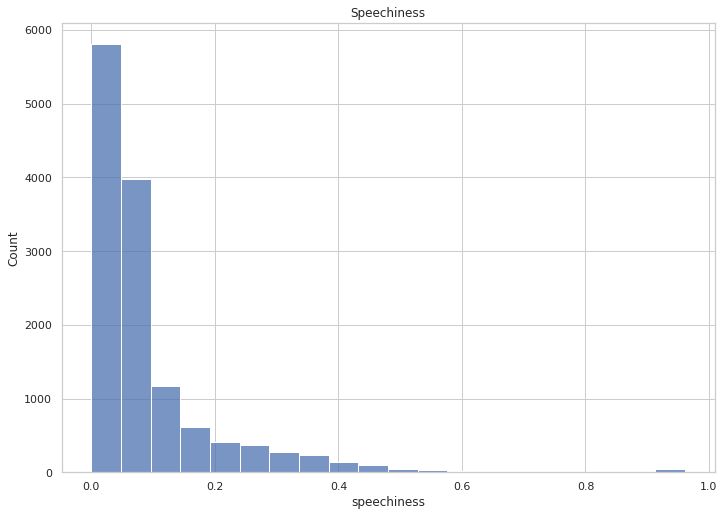

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'speechiness', bins = 20).set(title = 'Speechiness')

count    13283.000000
mean         0.097425
std          0.113599
min          0.000000
25%          0.037400
50%          0.053200
75%          0.101000
max          0.961000
Name: speechiness, dtype: float64

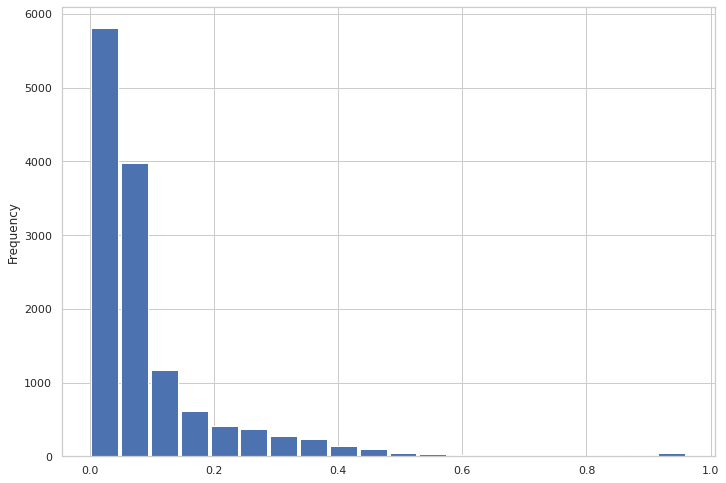

In [ ]:
df['speechiness'].plot.hist(grid=True, bins=20, rwidth=0.9)
df['speechiness'].describe()

[Text(0.5, 1.0, 'Acousticness')]

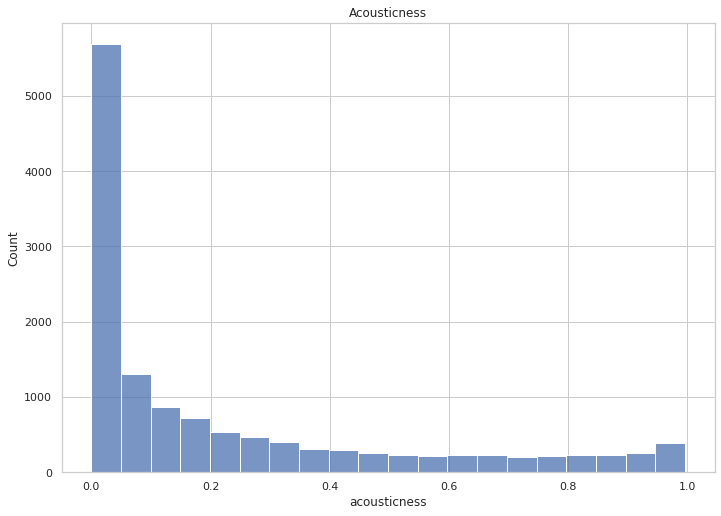

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'acousticness', bins = 20).set(title = 'Acousticness')

count    13283.000000
mean         0.226176
std          0.289517
min          0.000000
25%          0.008415
50%          0.083900
75%          0.349500
max          0.996000
Name: acousticness, dtype: float64

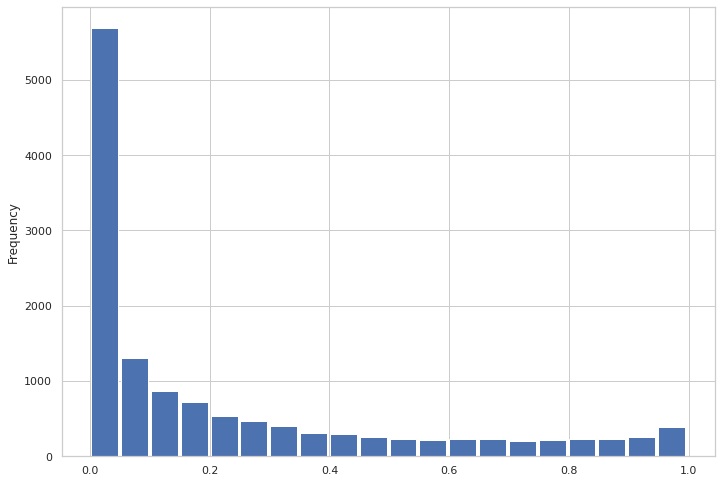

In [ ]:
df['acousticness'].plot.hist(grid=True, bins=20, rwidth=0.9)
df['acousticness'].describe()

count    13283.000000
mean         0.169908
std          0.323072
min          0.000000
25%          0.000000
50%          0.000042
75%          0.077550
max          1.000000
Name: instrumentalness, dtype: float64

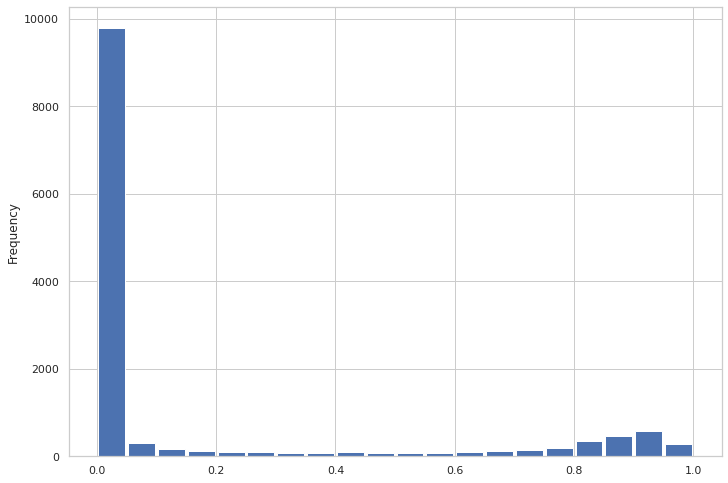

In [ ]:
df['instrumentalness'].plot.hist(grid=True, bins=20, rwidth=0.9)
df['instrumentalness'].describe()

[Text(0.5, 1.0, 'Instrumentalness')]

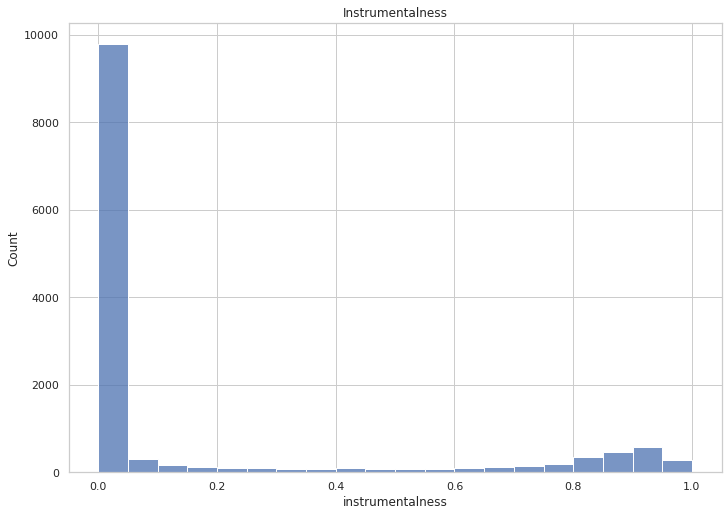

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'instrumentalness', bins = 20).set(title = 'Instrumentalness')

[Text(0.5, 1.0, 'Instrumentalness')]

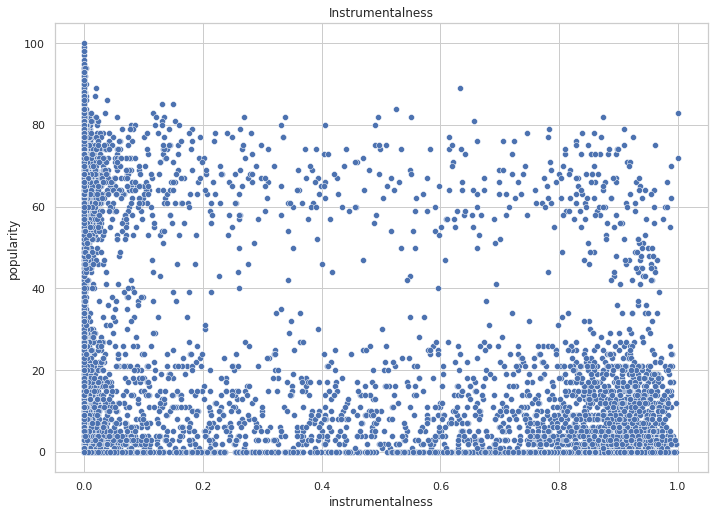

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.scatterplot(data = df, x = 'instrumentalness', y = 'popularity').set(title = 'Instrumentalness')

count    13283.000000
mean         0.215766
std          0.185137
min          0.000000
25%          0.098800
50%          0.134000
75%          0.287000
max          0.994000
Name: liveness, dtype: float64

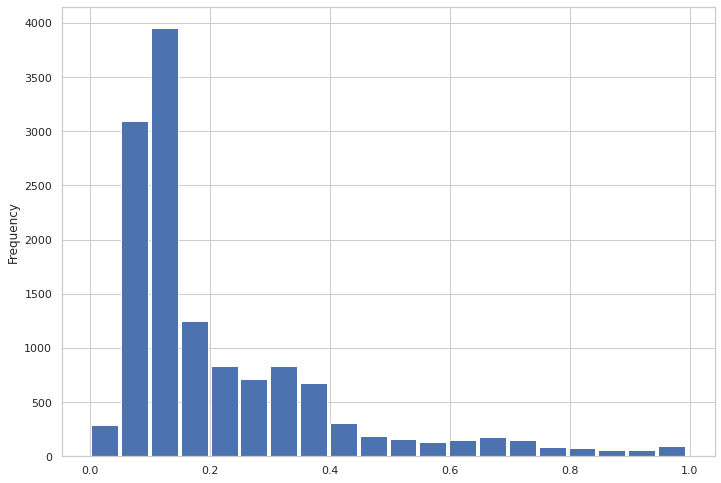

In [ ]:
df['liveness'].plot.hist(grid=True, bins=20, rwidth=0.9)
df['liveness'].describe()

[Text(0.5, 1.0, 'Liveness')]

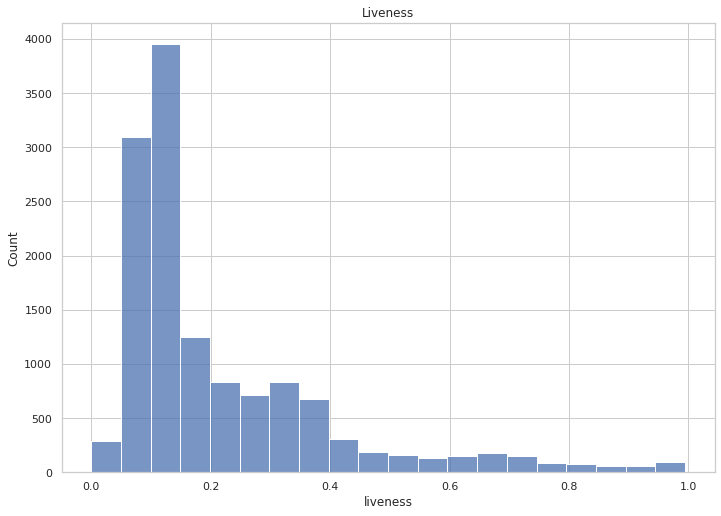

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'liveness', bins = 20).set(title = 'Liveness')

[Text(0.5, 1.0, 'valence')]

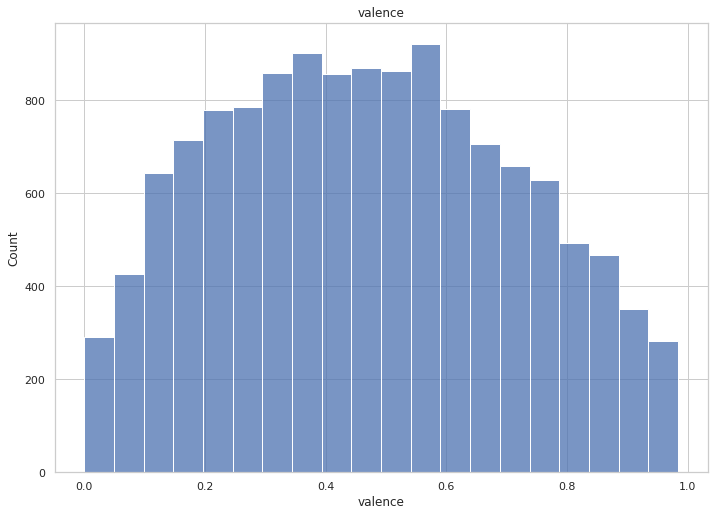

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'valence', bins = 20).set(title = 'valence')

count    13283.000000
mean         0.471164
std          0.243032
min          0.000000
25%          0.275000
50%          0.464000
75%          0.657000
max          0.984000
Name: valence, dtype: float64

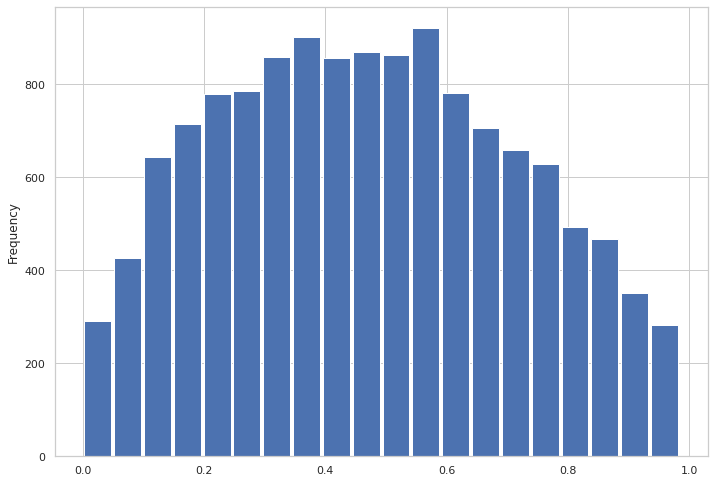

In [ ]:
df['valence'].plot.hist(grid=True, bins=20, rwidth=0.9)
df['valence'].describe()

count    13283.000000
mean       122.483868
std         27.683349
min          0.000000
25%        100.680500
50%        125.027000
75%        138.026000
max        220.099000
Name: tempo, dtype: float64

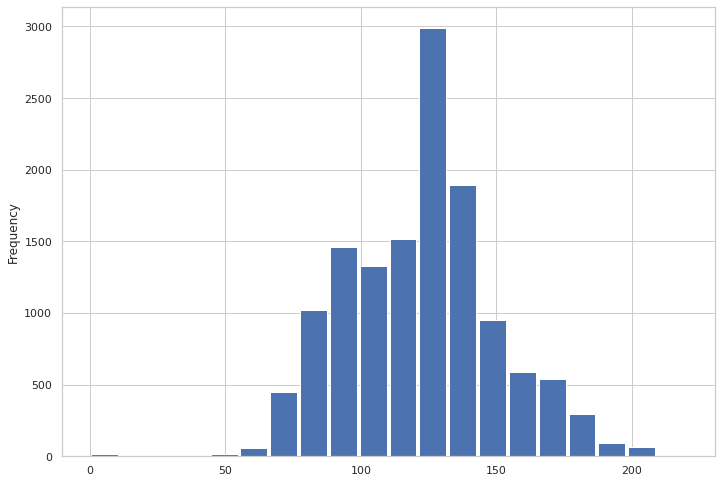

In [ ]:
df['tempo'].plot.hist(grid=True, bins=20, rwidth=0.9)
df['tempo'].describe()

count    1.328300e+04
mean     2.358598e+05
std      2.521494e+05
min      6.360000e+03
25%      1.757205e+05
50%      2.137080e+05
75%      2.547450e+05
max      5.042185e+06
Name: duration_ms, dtype: float64

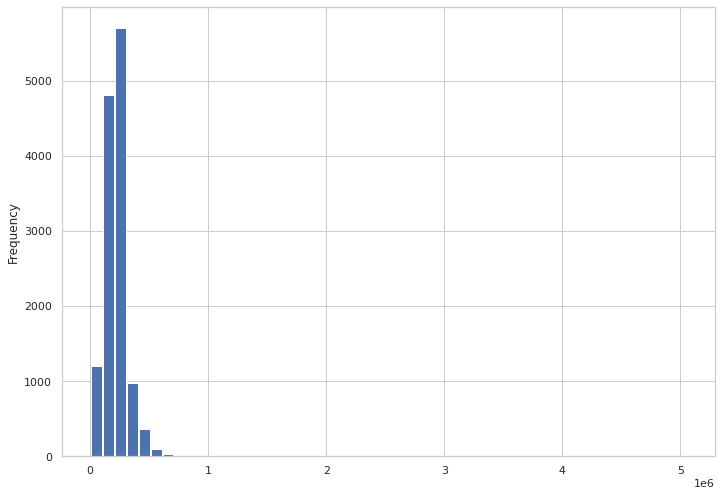

In [ ]:
df['duration_ms'].plot.hist(grid=True, bins=50, rwidth=0.9)
df['duration_ms'].describe()

[Text(0.5, 1.0, 'Duration in milliseconds')]

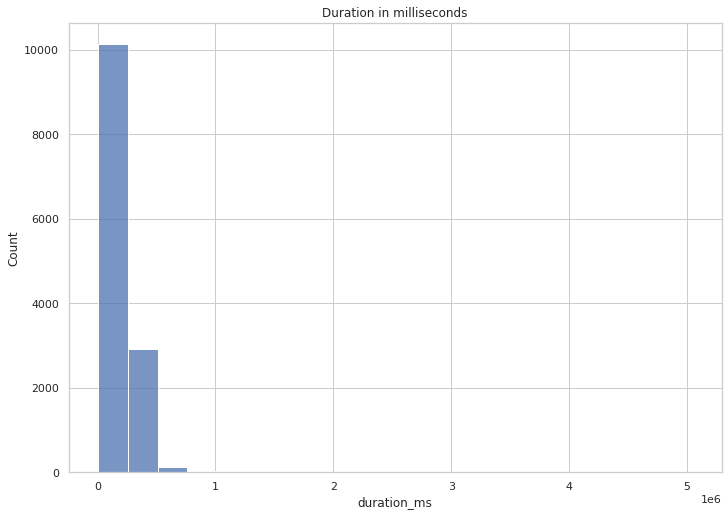

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'duration_ms', bins = 20).set(title = 'Duration in milliseconds')

[Text(0.5, 1.0, 'Popularity vs Duration in milliseconds')]

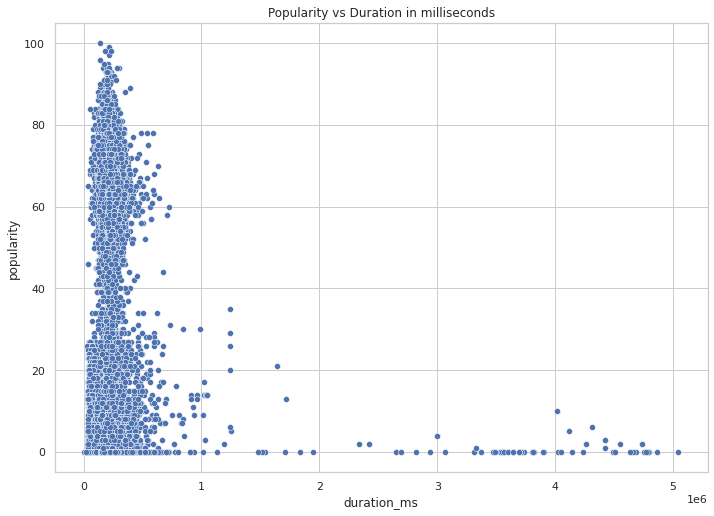

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.scatterplot(data = df, x = 'duration_ms', y = 'popularity').set(title = 'Popularity vs Duration in milliseconds')

[Text(0.5, 1.0, 'Popularity vs Time signature')]

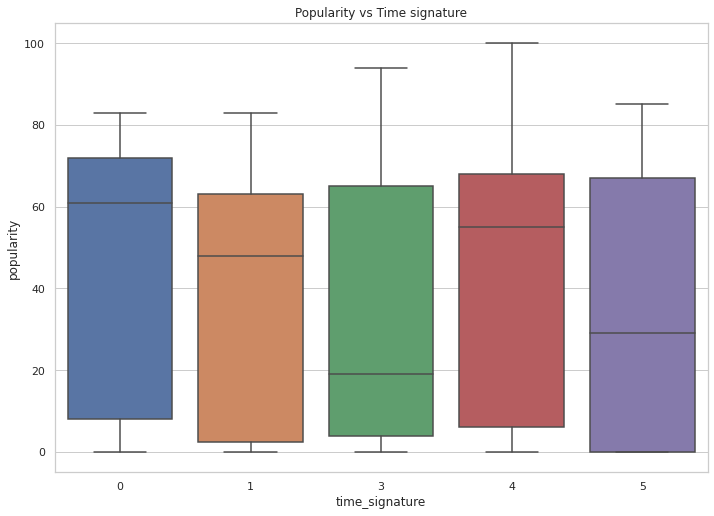

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.boxplot(data = df, x = 'time_signature', y = 'popularity').set(title = 'Popularity vs Time signature')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


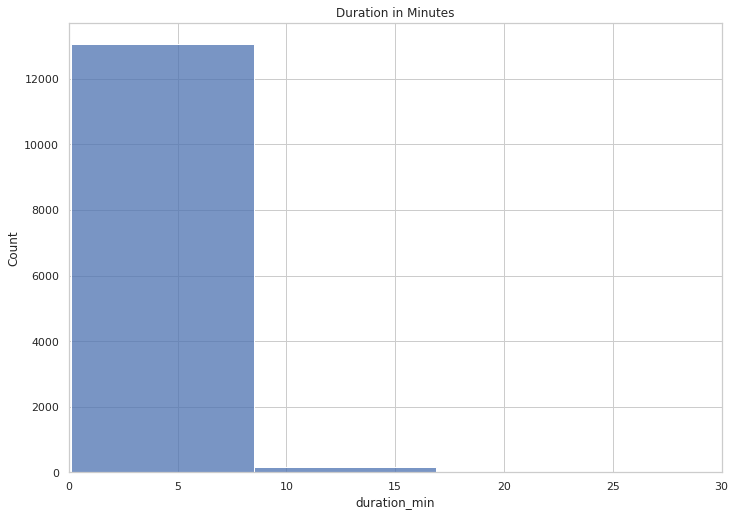

In [ ]:
df_duration = df[['duration_ms', 'popularity']]
df_duration['duration_s'] = df_duration.duration_ms / 1000
df_duration['duration_min'] = df_duration.duration_s / 60
#df_duration.head()
sns.histplot(data = df_duration, x = 'duration_min', bins = 10).set(title = 'Duration in Minutes', xlim = (0,30))

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
#sns.scatterplot(data = df_duration, x = 'duration_min', y = 'popularity').set(title = 'Popularity vs Duration in Minutes', xlim = (0,30))

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

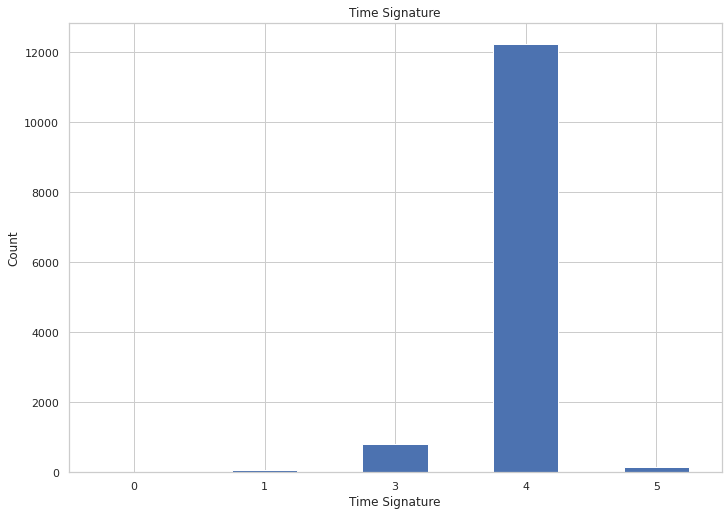

In [ ]:
df['time_signature'].value_counts().sort_index(ascending=False).plot(kind = "bar", xlabel = 'Time Signature', ylabel = 'Count').set(title = 'Time Signature')
df['time_signature'].describe()
df['time_signature'].value_counts()
ax = plt.gca()
ax.invert_xaxis()
plt.xticks(rotation=0)
#plt.invert_xaxis()

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

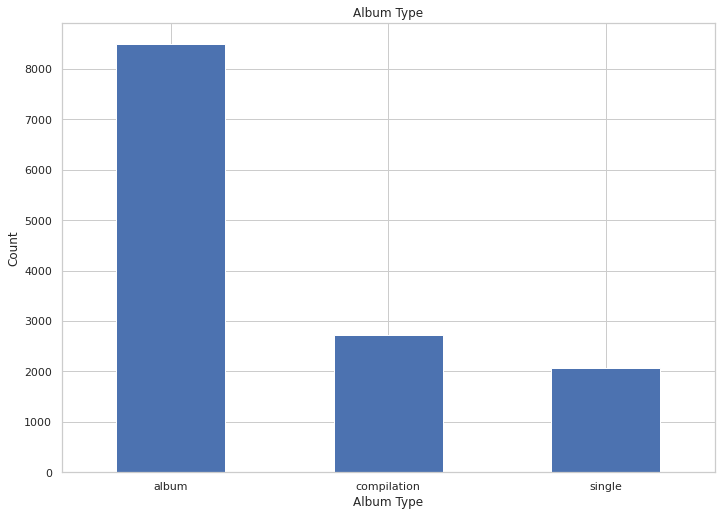

In [ ]:
df['album_type'].value_counts().sort_index(ascending=False).plot(kind = "bar", xlabel = 'Album Type', ylabel = 'Count').set(title = 'Album Type')
ax = plt.gca()
ax.invert_xaxis()
plt.xticks(rotation=0)
#plt.invert_xaxis()

[Text(0.5, 1.0, 'Duration in milliseconds')]

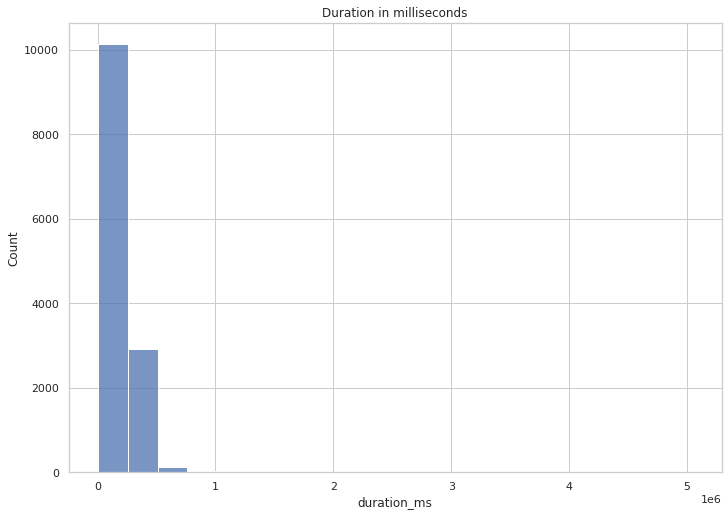

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
sns.histplot(data = df, x = 'duration_ms', bins = 20).set(title = 'Duration in milliseconds')

## Further analysis

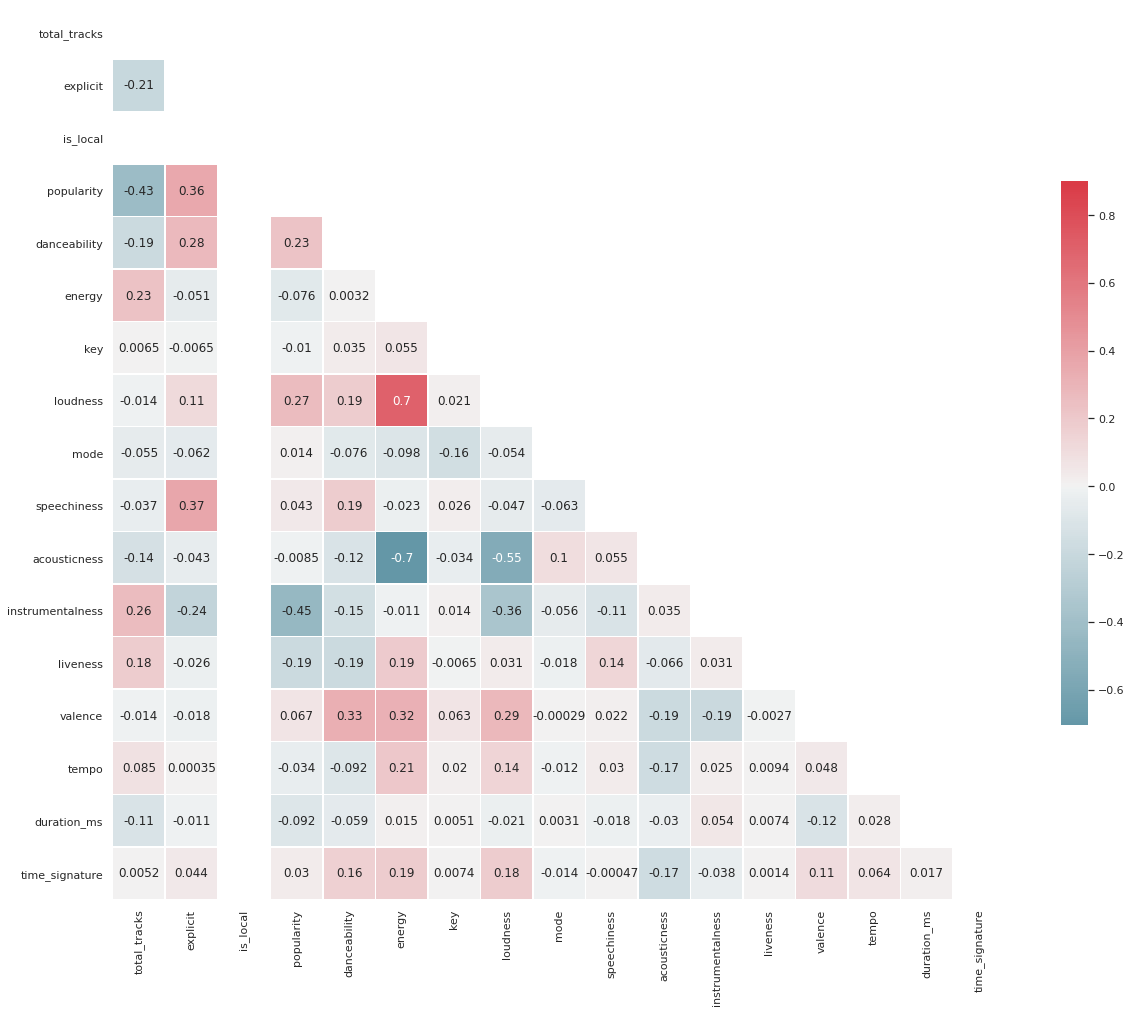

In [ ]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})